In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

In [2]:
def calculate_cumulative_variance(estimations):
    variances = np.zeros_like(estimations)
    for i in range(1, len(estimations)):
        variances[i] = np.var(estimations[:(i+1)], ddof=1) # ddof=1 daje nieobciążony estymator
    return variances

def theoretical_call_price(S_0, T, K, sg, r):
    def d_param(S_0, T, K, sg, r, plus):
        return (np.log(S_0/K) + (r+(sg**2)/2)*T)/(sg*np.sqrt(T)) if plus else (np.log(S_0/K) + (r-(sg**2)/2)*T)/(sg*np.sqrt(T))
    return S_0*norm.cdf(d_param(S_0, T, K, sg, r, True)) - K*np.exp(-r*T)*norm.cdf(d_param(S_0, T, K, sg, r, False))

def visualize_method(theoretical_prices, price_estimates, variance_estimates, strikes, method_name, second_col = True):
    plt.figure(figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(price_estimates[0], label="Estimation", color="blue")
    if theoretical_prices[0]:
        plt.axhline(y=theoretical_prices[0], label="Theoretical value", color="red")
    plt.title(f"K = {strikes[0]} - "+method_name)
    plt.legend()
    if second_col:
        plt.subplot(2, 2, 2)
        plt.plot(variance_estimates[0], label="Variance estimation", color="blue")
        plt.title("Unbiased variance estimation")
        plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(price_estimates[1], label="Estimation", color="blue")
    if theoretical_prices[1]:
        plt.axhline(y=theoretical_prices[1], label="Theoretical value", color="red")
    plt.title(f"K = {strikes[1]} - "+method_name)
    plt.legend()
    if second_col:
        plt.subplot(2, 2, 4)
        plt.plot(variance_estimates[1], label="Variance estimation", color="blue")
        plt.title("Unbiased variance estimation")
        plt.legend()


# Parametry rynku

In [3]:
S_0 = 100
r = 0.1
T = 1
sg = 1
K_1 = 80
K_2 = 120
CALL_1_THEO = theoretical_call_price(S_0, T, K_1, sg, r)
CALL_2_THEO = theoretical_call_price(S_0, T, K_2, sg, r)
title1 = "K = 80"
title2 = "K = 120"
discount = np.exp(-r*T)

# Inicjacja losowości

In [4]:
np.random.seed(42)
n_samples = 100000
randoms = np.random.normal(0,1,n_samples)
mean_maker = np.arange(1,n_samples+1)
exponent = (sg*np.sqrt(T) * randoms) + (r - (sg**2)/2)*T
stock_prices = S_0*np.exp(exponent)

call_payoffs1 = stock_prices - K_1
call_payoffs2 = stock_prices - K_2

call_payoffs1[call_payoffs1 < 0] = 0
call_payoffs2[call_payoffs2 < 0] = 0

call_payoffs1 *= np.exp(-r*T)
call_payoffs2 *= np.exp(-r*T)


# 1. Wycena Call

## 1.0 czysta woda

In [5]:
#kalkulacja
basic_variances_1 = calculate_cumulative_variance(call_payoffs1)
basic_estimates_1 = np.cumsum(call_payoffs1)
basic_estimates_1/=mean_maker
basic_variances_2 = calculate_cumulative_variance(call_payoffs2)
basic_estimates_2 = np.cumsum(call_payoffs2)
basic_estimates_2/=mean_maker

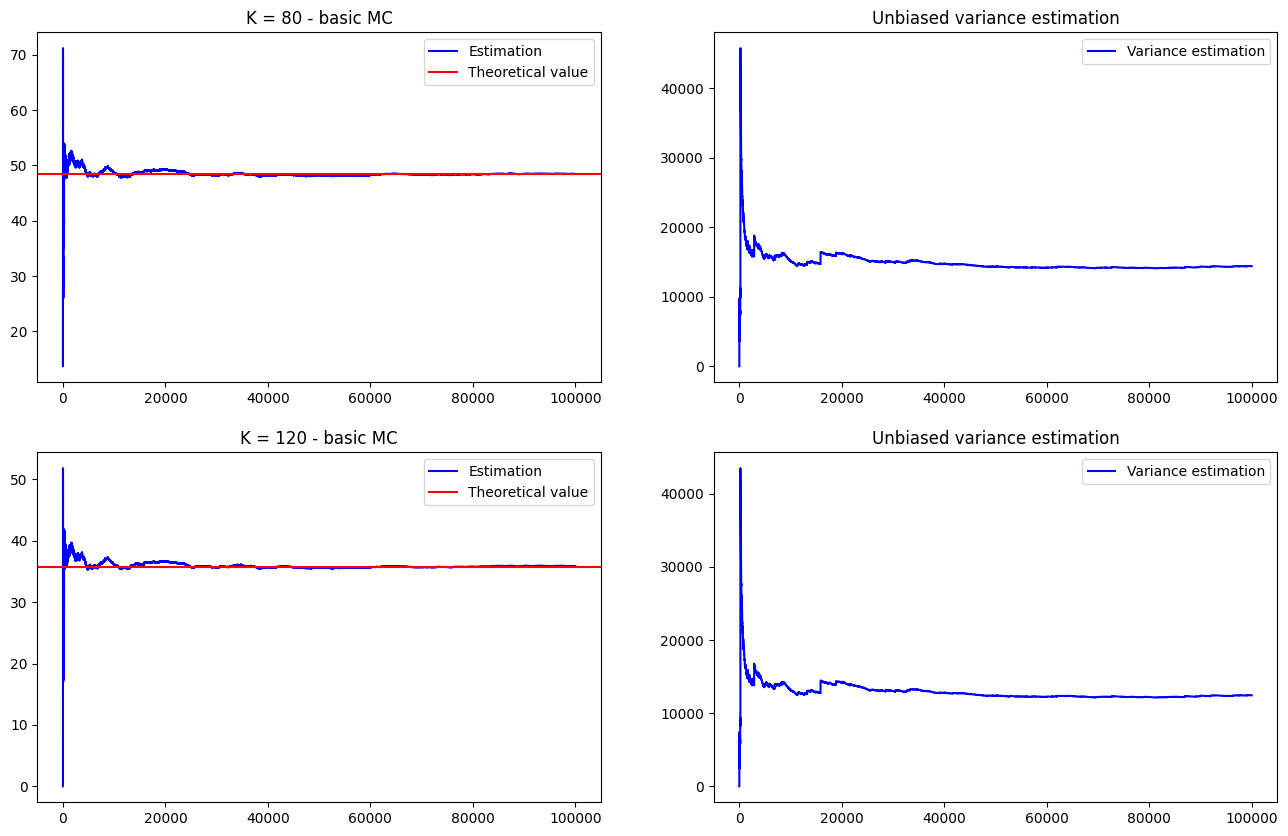

In [6]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [basic_estimates_1, basic_estimates_2], [basic_variances_1,basic_variances_2], [80,120], 'basic MC')
#wykresy są bardzo podobne (w przypadku wariancji identyczne - ta sama losowość)

## 1. a) - zmienna kontrolna

In [7]:
#wartość oczekiwana zmiennej kontrolnej
b = np.exp(-r*T)
tau = S_0*np.exp(r*T)

control_variate_payoffs1 = call_payoffs1 + (tau - stock_prices) * b
control_variate_payoffs2 = call_payoffs2 + (tau - stock_prices) * b

control_variate_variances_1 = calculate_cumulative_variance(control_variate_payoffs1)
control_variate_variances_2 = calculate_cumulative_variance(control_variate_payoffs2)

control_variate_means = (np.cumsum(stock_prices) / mean_maker)

control_variate_estimates_1 = basic_estimates_1 + (tau - control_variate_means) * b
control_variate_estimates_2 = basic_estimates_2 + (tau - control_variate_means) * b

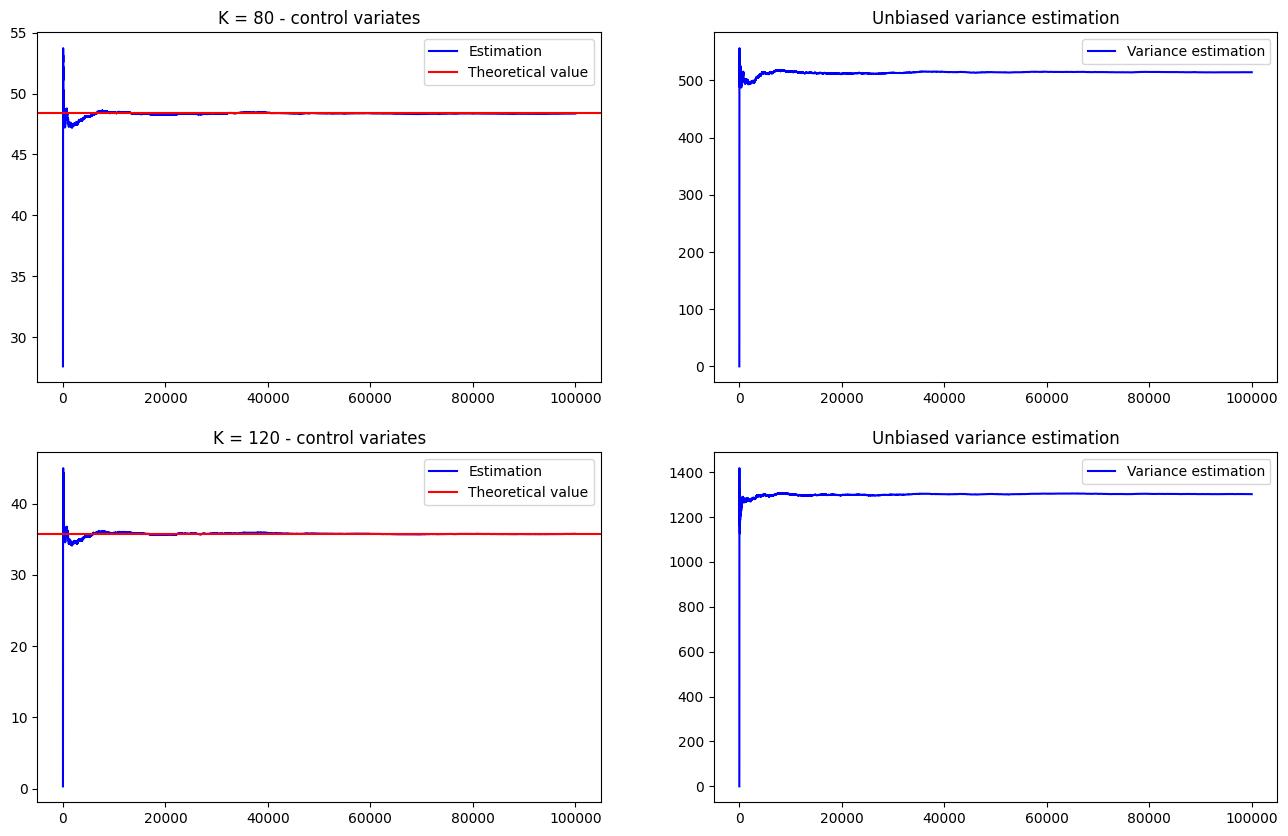

In [8]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [control_variate_estimates_1, control_variate_estimates_2], [control_variate_variances_1, control_variate_variances_2], [80,120], 'control variates')

## 1. b) - zmienna kontrolna z wyestymowanym współczynnikiem

In [9]:
#współczynniki b estymujemy dla 1000 próbek
n_small = 1000
randoms_small = np.random.normal(0,1,n_small)
exponent_small = (sg*np.sqrt(T) * randoms_small) + (r - (sg**2)/2)*T
stock_prices_small = S_0*np.exp(exponent_small)

call_payoffs1_small = stock_prices_small - K_1
call_payoffs2_small = stock_prices_small - K_2

call_payoffs1_small[call_payoffs1_small < 0] = 0
call_payoffs2_small[call_payoffs2_small < 0] = 0

call_payoffs1_small *= np.exp(-r*T)
call_payoffs2_small *= np.exp(-r*T)

small_mean1 = np.mean(call_payoffs1_small)
small_mean2 = np.mean(call_payoffs2_small)

centered_payoffs1_small = call_payoffs1_small - small_mean1
centered_payoffs2_small = call_payoffs2_small - small_mean2

control_variate_mean = np.mean(stock_prices_small)
centered_control_variate = stock_prices_small - control_variate_mean

numerator1 = np.sum(centered_payoffs1_small*centered_control_variate)
numerator2 = np.sum(centered_payoffs2_small*centered_control_variate)
denominator = np.sum(centered_control_variate**2)

b1 = numerator1 / denominator
b2 = numerator2 / denominator

control_variate_estimated_coef_payoffs1 = call_payoffs1 + (tau - stock_prices) * b1
control_variate_estimated_coef_payoffs2 = call_payoffs2 + (tau - stock_prices) * b2

control_variate_variances_estimated_coef1 = calculate_cumulative_variance(control_variate_estimated_coef_payoffs1)
control_variate_variances_estimated_coef2 = calculate_cumulative_variance(control_variate_estimated_coef_payoffs2)


control_variate_estimated_coef_estimates1 = basic_estimates_1 + (tau - control_variate_means) * b1
control_variate_estimated_coef_estimates2 = basic_estimates_2 + (tau - control_variate_means) * b2

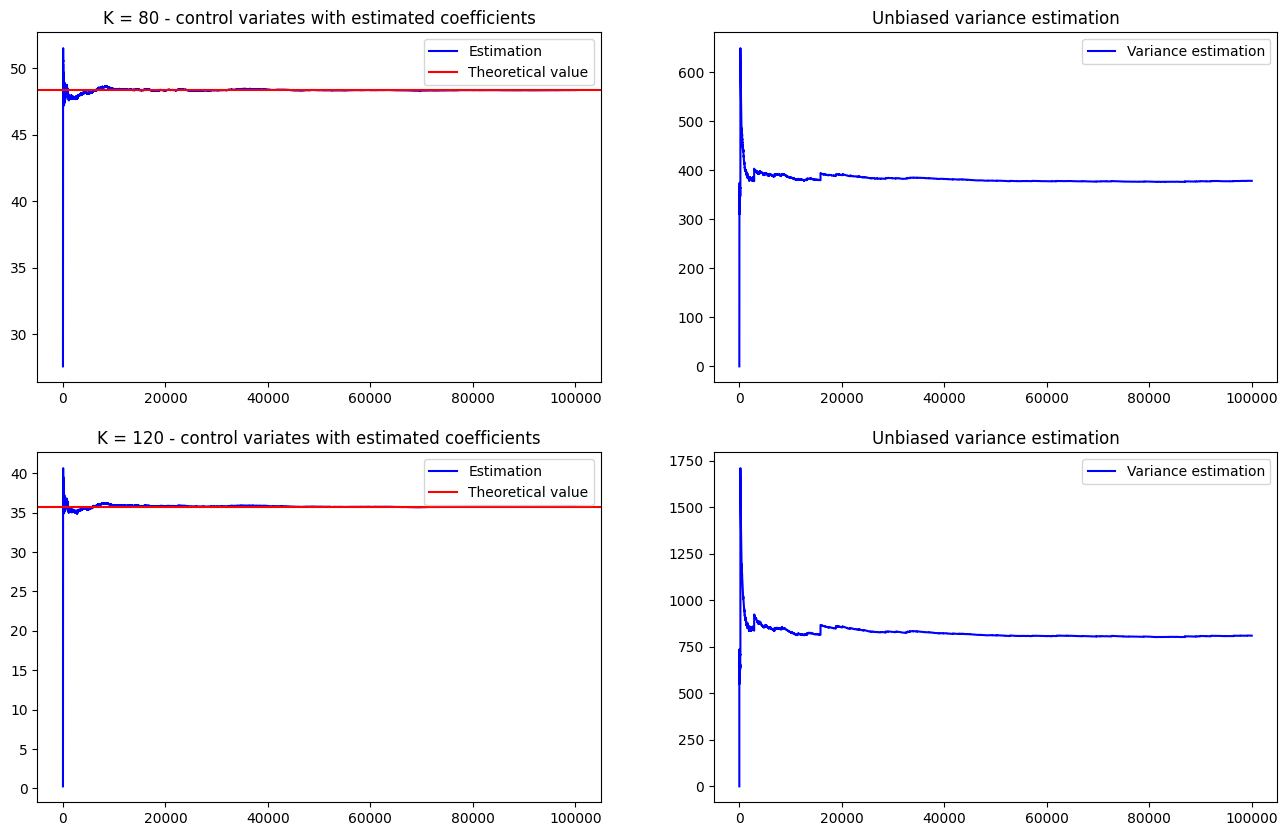

In [10]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [control_variate_estimated_coef_estimates1, control_variate_estimated_coef_estimates2], [control_variate_variances_estimated_coef1, control_variate_variances_estimated_coef2], [80,120], 'control variates with estimated coefficients')
#w tym wypadku nie istnieje estymator z pojedynczej próbki w związku z czym nie ma wykresu wariancji

## 1. c) - zmienne antytetyczne

In [11]:
antiexponent = (sg*np.sqrt(T) * (-randoms)) + (r - (sg**2)/2)*T
antistock_prices = S_0*np.exp(antiexponent)

anticall_payoffs1 = antistock_prices - K_1
anticall_payoffs2 = antistock_prices - K_2

anticall_payoffs1[anticall_payoffs1 < 0] = 0
anticall_payoffs2[anticall_payoffs2 < 0] = 0

anticall_payoffs1 *= np.exp(-r*T)
anticall_payoffs2 *= np.exp(-r*T)

merged_payoffs1 = (anticall_payoffs1 + call_payoffs1) / 2
merged_payoffs2 = (anticall_payoffs2 + call_payoffs2) / 2

merged_variances_1 = calculate_cumulative_variance(merged_payoffs1)
merged_estimates_1 = np.cumsum(merged_payoffs1)
merged_estimates_1/=mean_maker
merged_variances_2 = calculate_cumulative_variance(merged_payoffs2)
merged_estimates_2 = np.cumsum(merged_payoffs2)
merged_estimates_2/=mean_maker

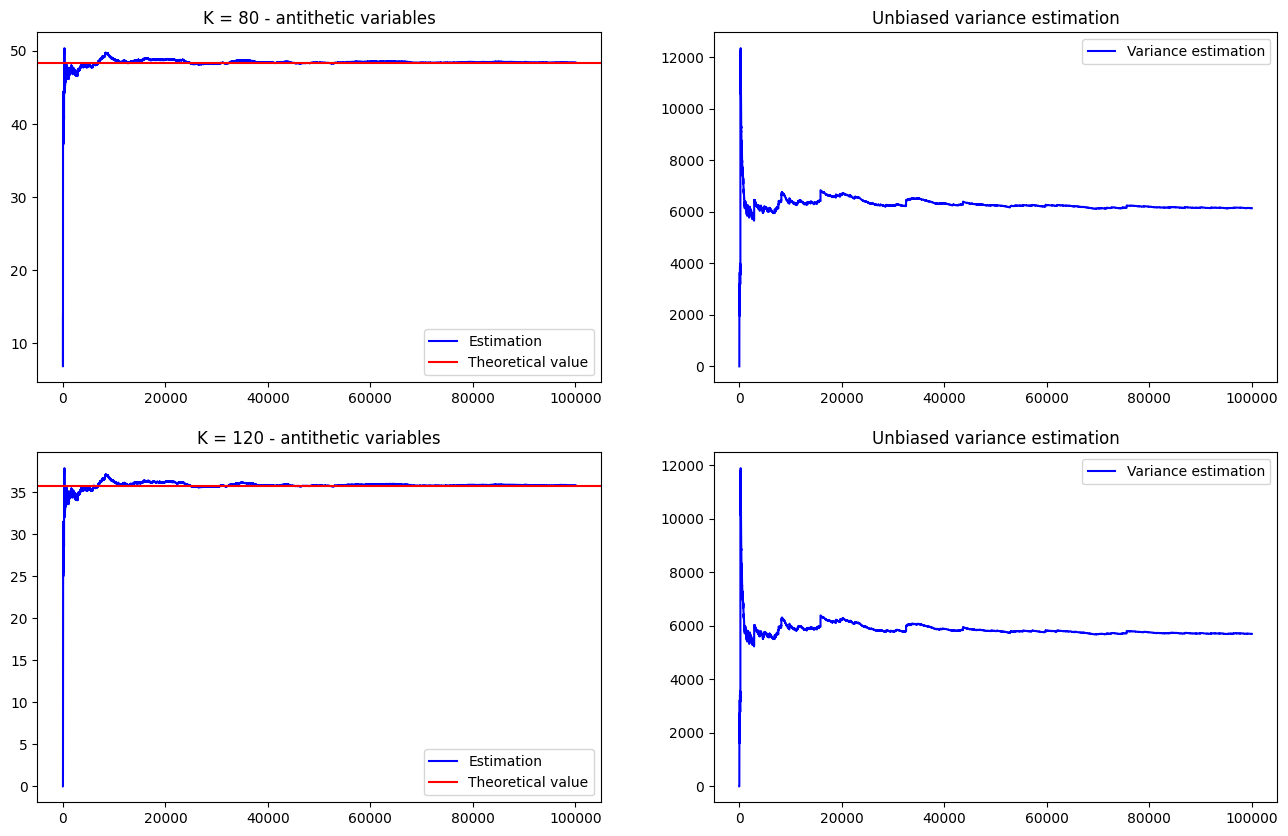

In [12]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [merged_estimates_1, merged_estimates_2], [merged_variances_1, merged_variances_2], [80,120], 'antithetic variables')

## 1. d) - stratified sampling

In [13]:
# wyekstrahujmy jednstostajną losowość z naszej normalnej próbki
uniforms = norm.cdf(randoms)
k = 100
subsamples = [[] for _ in range(k)]
for i in range(k):
    for j in range(n_samples//k):
        idx = i*k + j
        sample = uniforms[idx]
        normal_sample = norm.ppf((i+sample)/k)
        subsamples[i].append(normal_sample)
samples_collected = []
for j in range(n_samples//k):
    for i in range(k):
        samples_collected.append(subsamples[i][j])
# nowe źródło losowości N(0,1) pobrókowane przedziałami przetasowane
samples_collected = np.array(samples_collected)

stratified_exponent = (sg*np.sqrt(T) * samples_collected) + (r - (sg**2)/2)*T
stratified_stock_prices = S_0*np.exp(stratified_exponent)

stratified_call_payoffs1 = stratified_stock_prices - K_1
stratified_call_payoffs2 = stratified_stock_prices - K_2

stratified_call_payoffs1[stratified_call_payoffs1 < 0] = 0
stratified_call_payoffs2[stratified_call_payoffs2 < 0] = 0

stratified_call_payoffs1 *= np.exp(-r*T)
stratified_call_payoffs2 *= np.exp(-r*T)

stratified_variances1 = calculate_cumulative_variance(stratified_call_payoffs1)
stratified_estimates1 = np.cumsum(stratified_call_payoffs1)
stratified_estimates1/=mean_maker

stratified_variances2 = calculate_cumulative_variance(stratified_call_payoffs2)
stratified_estimates2 = np.cumsum(stratified_call_payoffs2)
stratified_estimates2/=mean_maker

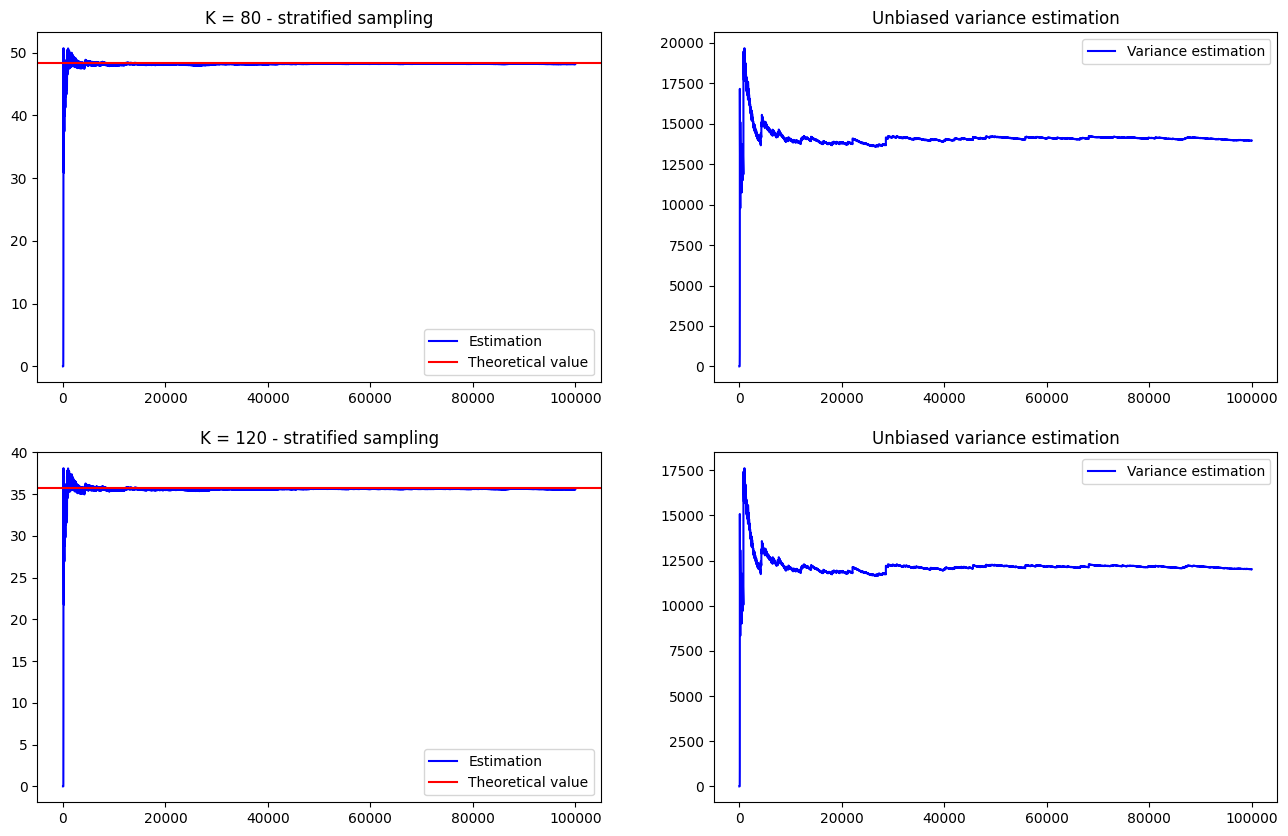

In [14]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [stratified_estimates1, stratified_estimates2], [stratified_variances1, stratified_variances2], [80,120], 'stratified sampling')
#płaskie wykresy wariancji mogą być zasługą bardziej tasowania niż warstwowania, violin-ploty prawdę powiedzą

## 1. e) - importance sampling

100%|██████████| 11/11 [00:49<00:00,  4.50s/it]
/tmp/ipykernel_18871/3507918406.py:28: RuntimeWarning: divide by zero encountered in log
  plt.plot(mus, np.log(imp_samp_vars1), color = "red", label = "K = 80")
/tmp/ipykernel_18871/3507918406.py:29: RuntimeWarning: divide by zero encountered in log
  plt.plot(mus, np.log(imp_samp_vars2), color = "blue", label = "K = 120")


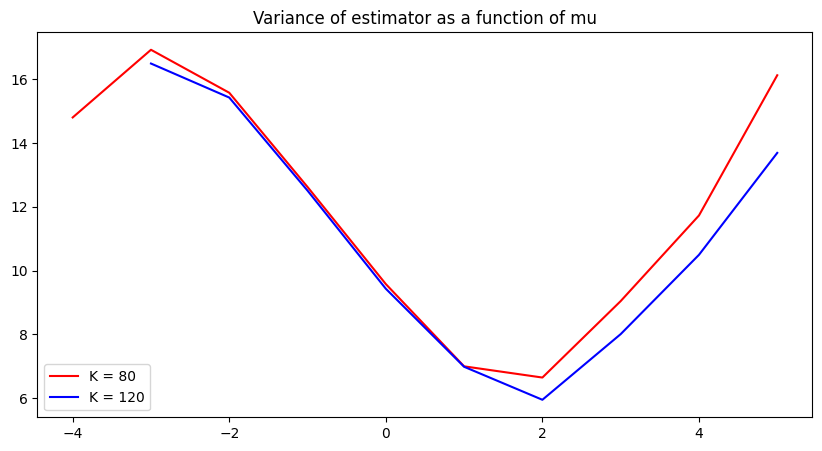

In [44]:
mus = np.linspace(-5,5,11)
imp_samp_vars1 = []
imp_samp_vars2 = []

for mu in tqdm(mus):
    Y = randoms + mu
    corrections = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu, T) for y in Y])
    exponent_Y = (sg*np.sqrt(T) * Y) + (r - (sg**2)/2)*T
    stock_prices_Y = S_0*np.exp(exponent_Y)

    call_payoffs1_Y = stock_prices_Y - K_1
    call_payoffs2_Y = stock_prices_Y - K_2

    call_payoffs1_Y[call_payoffs1_Y < 0] = 0
    call_payoffs2_Y[call_payoffs2_Y < 0] = 0

    call_payoffs1_Y *= np.exp(-r*T)
    call_payoffs2_Y *= np.exp(-r*T)

    call_payoffs1_Y *= corrections
    call_payoffs2_Y *= corrections

    imp_samp_vars1.append(np.var(call_payoffs1_Y, ddof=1))
    imp_samp_vars2.append(np.var(call_payoffs2_Y, ddof=1))
imp_samp_vars1 = np.array(imp_samp_vars1)
imp_samp_vars2 = np.array(imp_samp_vars2)
plt.figure(figsize=(10,5))
plt.plot(mus, np.log(imp_samp_vars1), color = "red", label = "K = 80")
plt.plot(mus, np.log(imp_samp_vars2), color = "blue", label = "K = 120")
plt.title("log(variance) of estimator as a function of mu")
plt.legend()

100%|██████████| 1001/1001 [1:15:31<00:00,  4.53s/it]


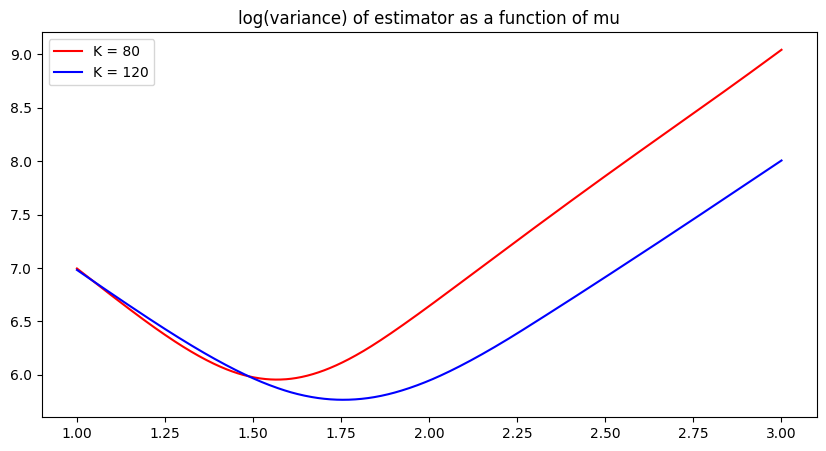

In [45]:
# dalej poszukamy między 1 a 3
mus = np.linspace(1,3,1001)
imp_samp_vars1 = []
imp_samp_vars2 = []

for mu in tqdm(mus):
    Y = randoms + mu
    corrections = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu, T) for y in Y])
    exponent_Y = (sg*np.sqrt(T) * Y) + (r - (sg**2)/2)*T
    stock_prices_Y = S_0*np.exp(exponent_Y)

    call_payoffs1_Y = stock_prices_Y - K_1
    call_payoffs2_Y = stock_prices_Y - K_2

    call_payoffs1_Y[call_payoffs1_Y < 0] = 0
    call_payoffs2_Y[call_payoffs2_Y < 0] = 0

    call_payoffs1_Y *= np.exp(-r*T)
    call_payoffs2_Y *= np.exp(-r*T)

    call_payoffs1_Y *= corrections
    call_payoffs2_Y *= corrections

    imp_samp_vars1.append(np.var(call_payoffs1_Y, ddof=1))
    imp_samp_vars2.append(np.var(call_payoffs2_Y, ddof=1))
imp_samp_vars1 = np.array(imp_samp_vars1)
imp_samp_vars2 = np.array(imp_samp_vars2)
imp_samp_vars1 = np.array(imp_samp_vars1)
imp_samp_vars2 = np.array(imp_samp_vars2)
plt.figure(figsize=(10,5))
plt.plot(mus, np.log(imp_samp_vars1), color = "red", label = "K = 80")
plt.plot(mus, np.log(imp_samp_vars2), color = "blue", label = "K = 120")
plt.title("log(variance) of estimator as a function of mu")
plt.legend()
#mu1 ustalimy na 1.6, mu2 na 1.8

In [15]:
mu1 = 1.6
mu2 = 1.8

Y1 = randoms + mu1
Y2 = randoms + mu2

corrections1 = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu1, T) for y in Y1])
corrections2 = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu2, T) for y in Y2])

exponent_Y1 = (sg*np.sqrt(T) * Y1) + (r - (sg**2)/2)*T
exponent_Y2 = (sg*np.sqrt(T) * Y2) + (r - (sg**2)/2)*T

stock_prices_Y1 = S_0*np.exp(exponent_Y1)
stock_prices_Y2 = S_0*np.exp(exponent_Y2)

call_payoffs1_Y1 = stock_prices_Y1 - K_1
call_payoffs2_Y2 = stock_prices_Y2 - K_2

call_payoffs1_Y1[call_payoffs1_Y1 < 0] = 0
call_payoffs2_Y2[call_payoffs2_Y2 < 0] = 0

call_payoffs1_Y1 *= np.exp(-r*T)
call_payoffs2_Y2 *= np.exp(-r*T)

call_payoffs1_Y1 *= corrections1
call_payoffs2_Y2 *= corrections2

imp_samp_cumul_vars1 = calculate_cumulative_variance(call_payoffs1_Y1)
imp_samp_cumul_vars2 = calculate_cumulative_variance(call_payoffs2_Y2)

imp_samp_estimates1 = np.cumsum(call_payoffs1_Y1) / mean_maker
imp_samp_estimates2 = np.cumsum(call_payoffs2_Y2) / mean_maker






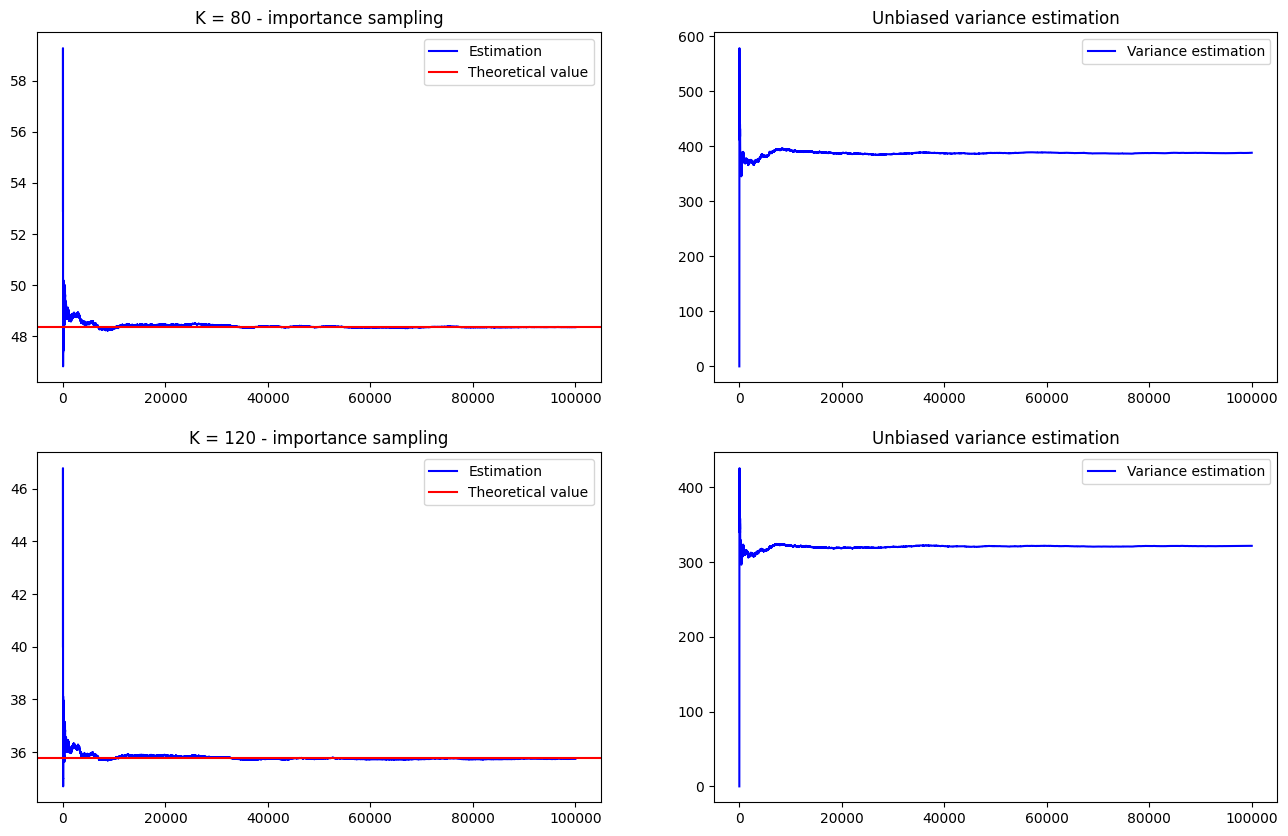

In [16]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [imp_samp_estimates1, imp_samp_estimates2], [imp_samp_cumul_vars1, imp_samp_cumul_vars2], [80,120], 'importance sampling')

## 1. - zbiorcze porównanie

In [17]:
colors = [
    '#FF595E',
    '#FFCA3A',
    '#8AC926',
    '#1982C4',
    '#6A4C93',
    '#FF924C'
]

In [18]:
def limit_array_to_range(array, lower, upper):
    return array[(array >= lower) & (array <= upper)]

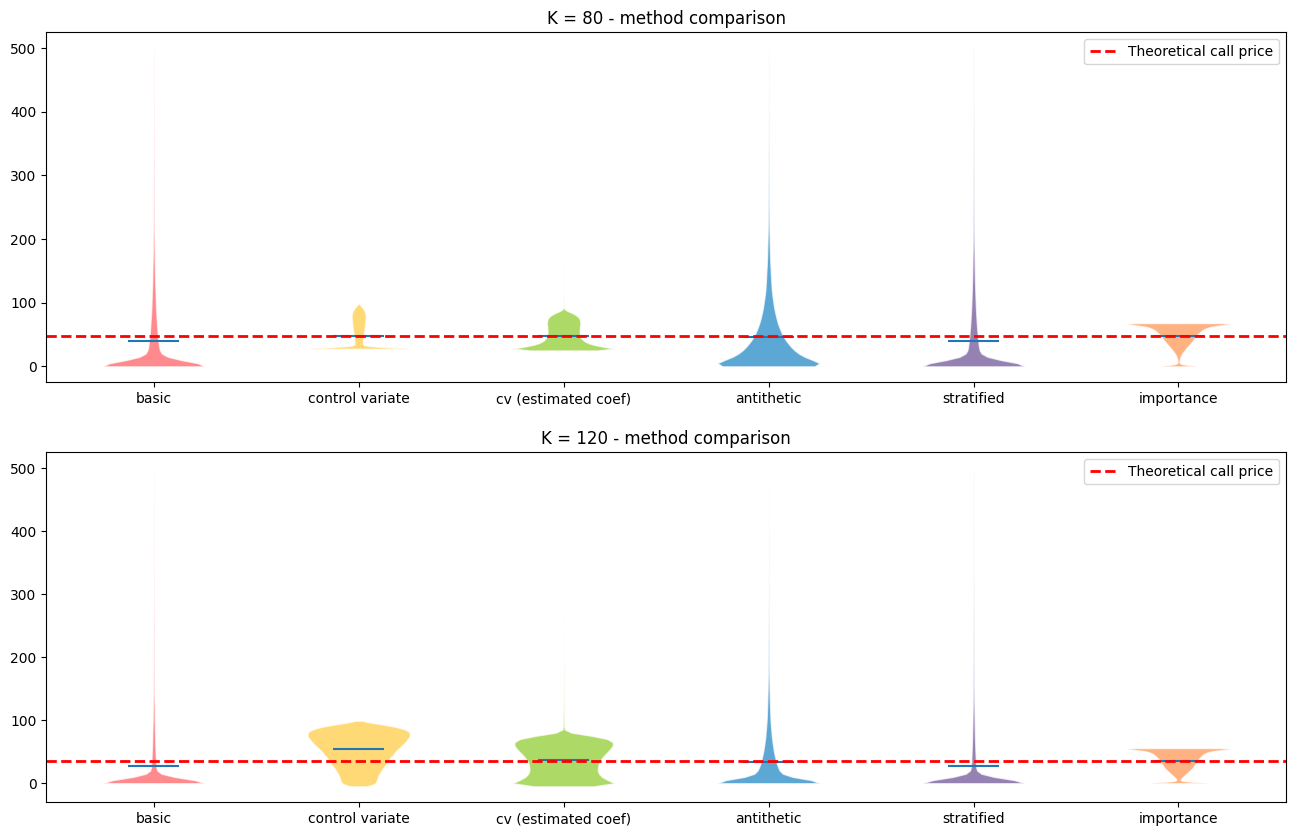

In [21]:
K1_data = [call_payoffs1, control_variate_payoffs1, control_variate_estimated_coef_payoffs1, merged_payoffs1, stratified_call_payoffs1, call_payoffs1_Y1]
K2_data = [call_payoffs2, control_variate_payoffs2, control_variate_estimated_coef_payoffs2, merged_payoffs2, stratified_call_payoffs2, call_payoffs2_Y2]
for i in range(len(K1_data)):
    K1_data[i] = limit_array_to_range(K1_data[i], -5,500)
    K2_data[i] = limit_array_to_range(K2_data[i], -5,500)

ticks = ['basic', 'control variate', 'cv (estimated coef)','antithetic', 'stratified', 'importance']
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
parts = plt.violinplot(K1_data, showmeans=True, showextrema=False)
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('white')
    body.set_alpha(0.7)
plt.axhline(y=CALL_1_THEO, color='red', linestyle='--', linewidth=2, label = "Theoretical call price")
plt.legend()
plt.xticks([1,2,3,4,5,6],ticks)
plt.title('K = 80 - method comparison')
plt.subplot(2,1,2)
parts = plt.violinplot(K2_data, showmeans=True, showextrema=False)
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('white')
    body.set_alpha(0.7)
plt.axhline(y=CALL_2_THEO, color='red', linestyle='--', linewidth=2, label = "Theoretical call price")
plt.legend()
plt.xticks([1,2,3,4,5,6],ticks)
plt.title('K = 120 - method comparison')
plt.show()
#odcinane są outliery, więc średnie mogą się co nieco porozjeżdzać

# 2. Azja

## 2.0 Losowość (trzeba generować całe trajektorie)

In [26]:
def generate_bs_trajectories(S0, r, sg, T, N, n):
    """
    Generate n trajectories of a stock price under the Black-Scholes model.

    Parameters:
    - S0: initial stock price
    - r: risk-free interest rate
    - sg: volatility
    - T: time horizon
    - N: number of time steps
    - n: number of trajectories

    Returns:
    - trajectories: (N+1) x n NumPy array, each column is a trajectory
    """
    dt = T / N
    t = np.linspace(0, T, N + 1)[:, None]  # shape (N+1, 1)

    # Generate (N, n) matrix of standard normals
    Z = np.random.randn(N, n)

    # Compute Brownian increments and cumulative sums (shape: N+1 x n)
    dW = np.sqrt(dt) * Z
    del Z
    W = np.vstack([np.zeros((1, n)), np.cumsum(dW, axis=0)])  # start from 0
    del dW

    # Compute trajectories
    drift = (r - 0.5 * sg**2) * t  # shape (N+1, 1)
    diffusion = sg * W  # shape (N+1, n)
    del W
    log_paths = drift + diffusion # broadcasting drift to all n paths
    del drift, diffusion
    S = S0 * np.exp(log_paths)  # shape (N+1, n)

    return S

In [27]:
np.random.seed(42)
N = 10000
Ts = np.linspace(0, T, N+1)
n_samples = 100000
trajectories = generate_bs_trajectories(S_0, r, sg, T, N, n_samples)
trajectories_arithmetic_mean = np.mean(trajectories, axis=0)
mean_maker = np.arange(1,n_samples + 1)



## 2.1 Bazowe MC

In [28]:
asian_arithmetic_payoffs1 = discount * (trajectories_arithmetic_mean - K_1)
asian_arithmetic_payoffs1[asian_arithmetic_payoffs1 < 0] = 0
asian_arithmetic_payoffs2 = discount * (trajectories_arithmetic_mean - K_2)
asian_arithmetic_payoffs2[asian_arithmetic_payoffs2 < 0] = 0

In [29]:
asian_arithmetic_variances1 = calculate_cumulative_variance(asian_arithmetic_payoffs1)
asian_arithmetic_estimates1 = np.cumsum(asian_arithmetic_payoffs1) / mean_maker
asian_arithmetic_variances2 = calculate_cumulative_variance(asian_arithmetic_payoffs2)
asian_arithmetic_estimates2 = np.cumsum(asian_arithmetic_payoffs2) / mean_maker

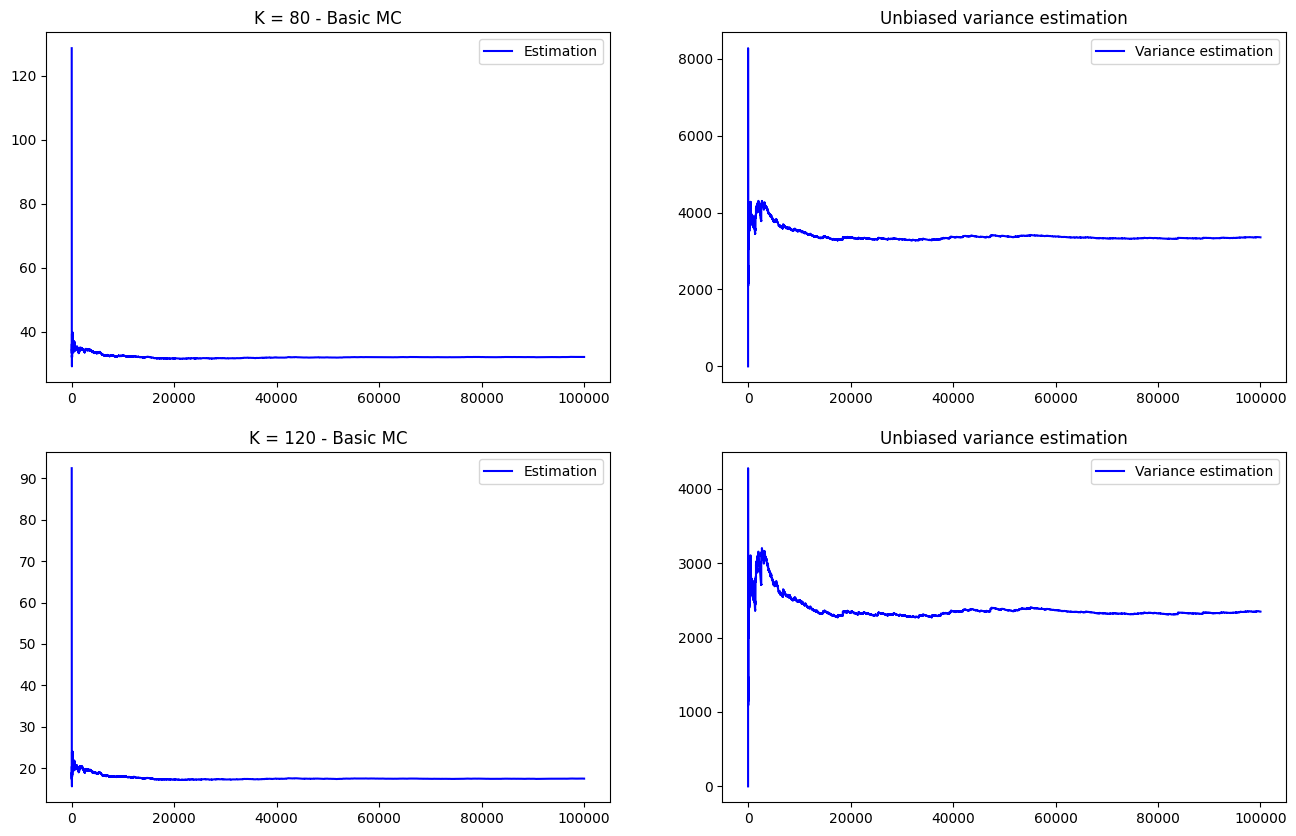

In [30]:
visualize_method([None,None], [asian_arithmetic_estimates1, asian_arithmetic_estimates2], [asian_arithmetic_variances1, asian_arithmetic_variances2], [80, 120], "Basic MC")

## 2.1 - zmienna kontrolna

In [31]:
def geometric_asian_call_price(S0, K, r, sigma, T, N):


    # średni czas (do uwzględnienia dryfu)
    t_bar = T * (N + 1) / (2 * N)

    # wariancja logarytmu iloczynu (bazuje na jakichś wzorach dyskretno-matematycznych)
    alpha2 = (sigma ** 2) * T * (N + 1) * (2 * N + 1) / (6 * N ** 2)
    alpha = np.sqrt(alpha2)

    # średnia logarytmu iloczynu (z wliczonym S_0)
    beta = np.log(S0) + (r - 0.5 * sigma ** 2) * t_bar

    # argumenty dystrybuant
    d1 = (beta - np.log(K) + alpha2) / alpha
    d2 = d1 - alpha

    # zastosowanie wzoru
    discounted_expectation = np.exp(-r * T) * (
            np.exp(beta + 0.5 * alpha2) * norm.cdf(d1) - K * norm.cdf(d2)
    )

    return discounted_expectation

In [32]:

asian_geometric_mean_expectation1 = geometric_asian_call_price(S_0, K_1, r, sg, T, N)
print(f"K = 80, geometric mean expectation: {asian_geometric_mean_expectation1}")
asian_geometric_mean_expectation2 = geometric_asian_call_price(S_0, K_2, r, sg, T, N)
print(f"K = 120, geometric mean expectation: {asian_geometric_mean_expectation2}")

K = 80, geometric mean expectation: 26.672017290492025
K = 120, geometric mean expectation: 13.230529010431464


In [33]:
trajectories_geometric_mean = np.exp(np.mean(np.log(trajectories), axis=0))
asian_geometric_payoffs1 = discount * (trajectories_geometric_mean - K_1)
asian_geometric_payoffs1[asian_geometric_payoffs1 < 0] = 0
asian_geometric_payoffs2 = discount * (trajectories_geometric_mean - K_2)
asian_geometric_payoffs2[asian_geometric_payoffs2 < 0] = 0

n_param_estimation = 1000
n_price_estimation = n_samples - n_param_estimation

geometric_payoffs_small1 = asian_geometric_payoffs1[:n_param_estimation]
geometric_payoffs_small2 = asian_geometric_payoffs2[:n_param_estimation]

geometric_payoffs_large1 = asian_geometric_payoffs1[n_param_estimation:]
geometric_payoffs_large2 = asian_geometric_payoffs2[n_param_estimation:]

asian_arithmetic_payoffs_small1 = asian_arithmetic_payoffs1[:n_param_estimation]
asian_arithmetic_payoffs_small2 = asian_arithmetic_payoffs2[:n_param_estimation]

asian_arithmetic_payoffs_large1 = asian_arithmetic_payoffs1[n_param_estimation:]
asian_arithmetic_payoffs_large2 = asian_arithmetic_payoffs2[n_param_estimation:]


geometric_mean_small1 = np.mean(geometric_payoffs_small1)
geometric_mean_small2 = np.mean(geometric_payoffs_small2)

centered_control_variate1 = geometric_payoffs_small1 - geometric_mean_small1
centered_control_variate2 = geometric_payoffs_small2 - geometric_mean_small2

denominator1 = np.var(centered_control_variate1)
denominator2 = np.var(centered_control_variate2)

numerator1 = np.mean(centered_control_variate1*asian_arithmetic_payoffs_small1)
numerator2 = np.mean(centered_control_variate2*asian_arithmetic_payoffs_small2)

b1 = numerator1 / denominator1
b2 = numerator2 / denominator2

In [34]:
control_variate_asian_payoffs1 = asian_arithmetic_payoffs_large1 + (asian_geometric_mean_expectation1 - geometric_payoffs_large1) * b1
control_variate_asian_payoffs2 = asian_arithmetic_payoffs_large2 + (asian_geometric_mean_expectation2 - geometric_payoffs_large2) * b2

In [35]:
mean_maker = np.arange(1, n_price_estimation+1)
control_variate_asian_variances1 = calculate_cumulative_variance(control_variate_asian_payoffs1)
control_variate_asian_estimates1 = np.cumsum(control_variate_asian_payoffs1) / mean_maker
control_variate_asian_variances2 = calculate_cumulative_variance(control_variate_asian_payoffs2)
control_variate_asian_estimates2 = np.cumsum(control_variate_asian_payoffs2) / mean_maker

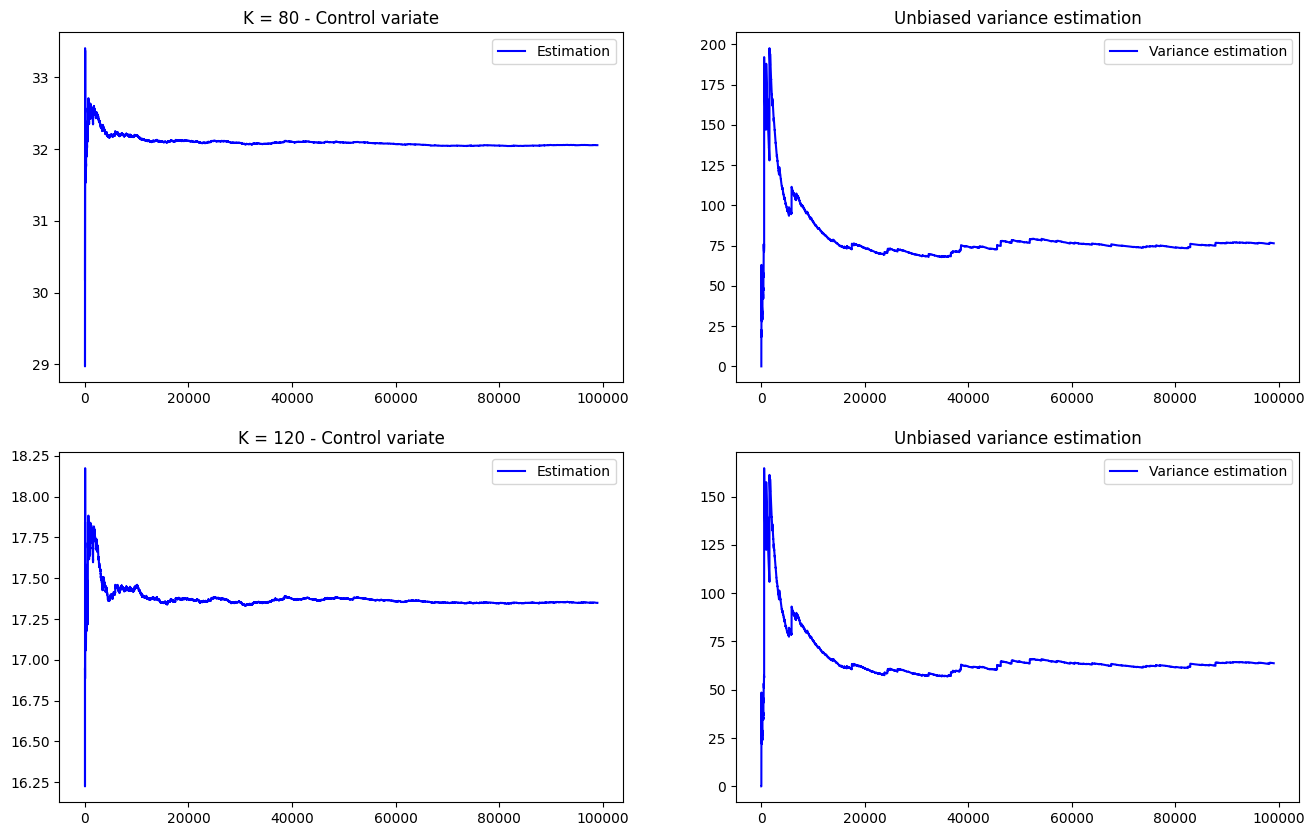

In [36]:
visualize_method([None, None], [control_variate_asian_estimates1, control_variate_asian_estimates2], [control_variate_asian_variances1, control_variate_asian_variances2], [80, 120], "Control variate")

## 2. Porównanie

In [40]:
colors = [
    '#FF595E',
    '#FFCA3A'
    ]

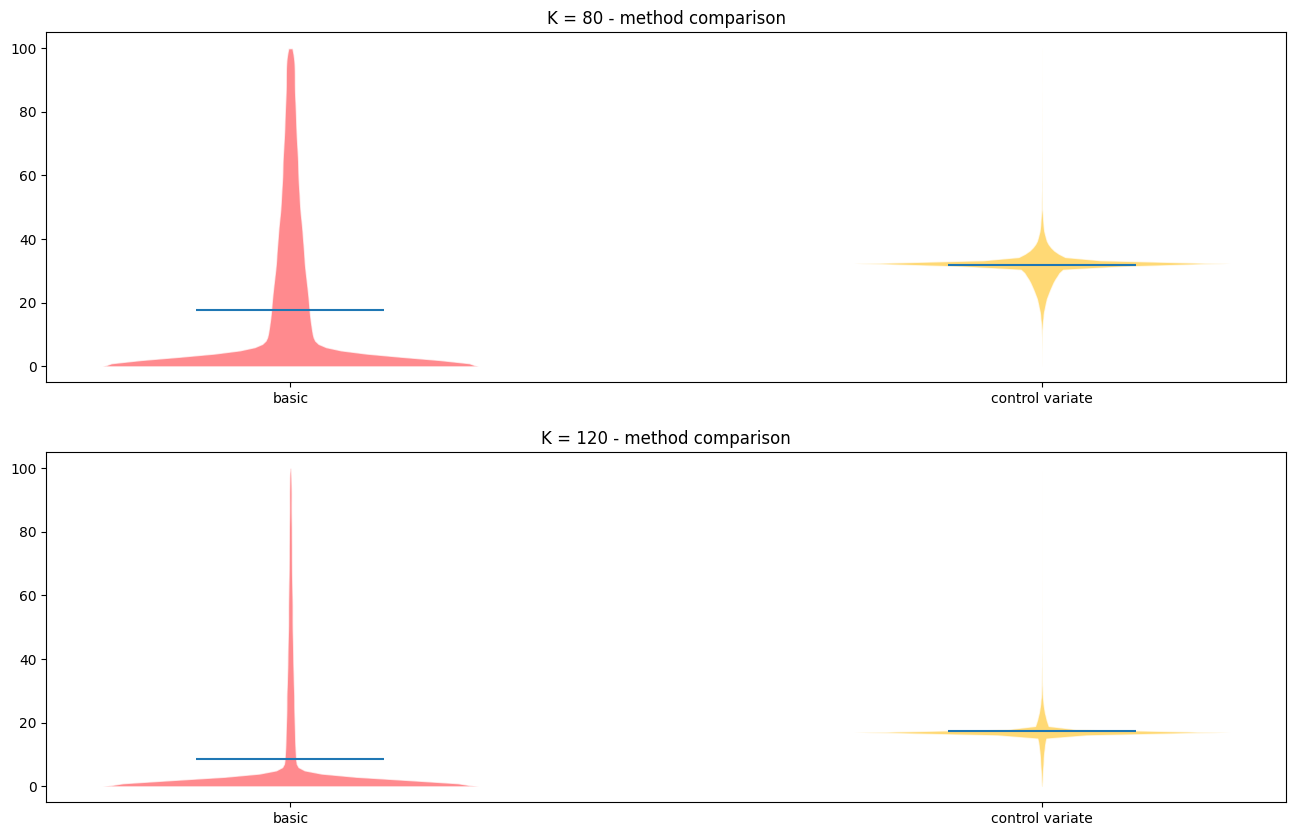

In [37]:
K1_asian_data = [asian_arithmetic_payoffs1, control_variate_asian_payoffs1]
K2_asian_data = [asian_arithmetic_payoffs2, control_variate_asian_payoffs2]
#ponownie nieco rozjechane średnie wynikają z obcięcia częśći obserwacji (bez niego wykresy są średnio czytelne)
for i in range(len(K1_asian_data)):
    K1_asian_data[i] = limit_array_to_range(K1_asian_data[i], 0,100)
    K2_asian_data[i] = limit_array_to_range(K2_asian_data[i], 0,100)

ticks = ['basic', 'control variate']
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
parts = plt.violinplot(K1_asian_data, showmeans=True, showextrema=False)
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('white')
    body.set_alpha(0.7)
plt.xticks([1,2],ticks)
plt.title('K = 80 - method comparison')
plt.subplot(2,1,2)
parts = plt.violinplot(K2_asian_data, showmeans=True, showextrema=False)
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('white')
    body.set_alpha(0.7)
plt.xticks([1,2],ticks)
plt.title('K = 120 - method comparison')
plt.show()

#### Widać, że więcej masy przy średniej

# Zad 3. spooky scary option

## parametry rynku

In [5]:
T = 10
S_0 = 100.0
sg = 1
r = 0.1
discount = np.exp(-r * T)
K1 = 200
K2 = 100

## trajektorie

In [6]:
np.random.seed(42)
N = 10000
Ts = np.linspace(0, T, N+1)
n_samples = 100000
trajectories = generate_bs_trajectories(S_0, r, sg, T, N, n_samples)

## obliczanie wypłaty

In [7]:
def price_spooky_scary_call(trajectory, T, K1, K2, n_tot_moments, n_check_moments, N, subtraction_times):
    moment_indices = [(N//n_tot_moments) * (i+1) for i in range(n_tot_moments)]
    more_than_K2 = 0
    for index in moment_indices:
        if trajectory[index] > K2:
            more_than_K2 += 1
    if more_than_K2 < n_check_moments:
        return 0
    payoff = K1
    idxs_per_sec = N / T
    for time in subtraction_times:
        payoff -= trajectory[int(time*idxs_per_sec)]
    return max(0, payoff)


## 3.1 bazowe_mc

In [8]:
n_tot_moments = 10
n_check_moments = 5
subtraction_times = [5, 10]

In [9]:
spooky_scary_payoffs = np.apply_along_axis(lambda trajectory: price_spooky_scary_call(trajectory, T, K1, K2, n_tot_moments, n_check_moments, N, subtraction_times), axis = 0, arr = trajectories) * discount
spooky_scary_variances = calculate_cumulative_variance(spooky_scary_payoffs)
mean_maker = np.arange(1, n_samples + 1)
spooky_scary_estimates = np.cumsum(spooky_scary_payoffs) / mean_maker

In [10]:
def visualize_method_single_parameters(theoretical_price, price_estimates, variance_estimates, call_name, method_name, second_col = True):
    plt.figure(figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(price_estimates, label="Estimation", color="blue")
    if theoretical_price:
        plt.axhline(y=theoretical_price, label="Theoretical value", color="red")
    plt.title(f"K = {call_name} - "+method_name)
    plt.legend()
    if second_col:
        plt.subplot(2, 2, 2)
        plt.plot(variance_estimates, label="Variance estimation", color="blue")
        plt.title("Unbiased variance estimation")
        plt.legend()


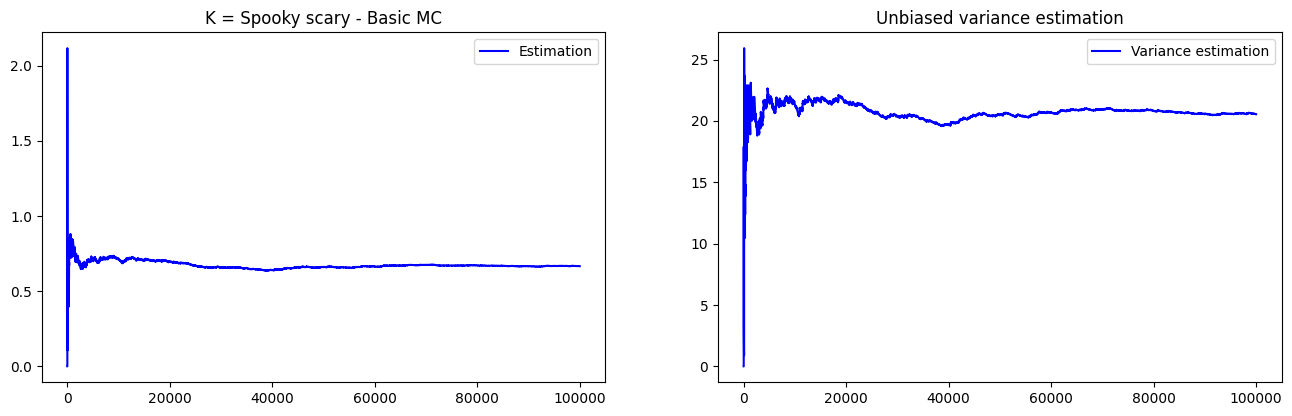

In [11]:
visualize_method_single_parameters(None, spooky_scary_estimates, spooky_scary_variances, "Spooky scary", "Basic MC")
del trajectories

## 3.2 Redukcja wariancji (zmienna kontrolna $(K_1 - S_5 - S_{10})^+$, i antytetyczna)

In [12]:
def generate_bs_trajectories_with_anithetic(S0, r, sg, T, N, n):
    dt = T / N
    t = np.linspace(0, T, N + 1)[:, None]  # shape (N+1, 1)

    # Generate (N, n) matrix of standard normals
    Z = np.random.randn(N, n)

    # Compute Brownian increments and cumulative sums (shape: N+1 x n)
    dW = np.sqrt(dt) * Z
    del Z
    W = np.vstack([np.zeros((1, n)), np.cumsum(dW, axis=0)])  # start from 0
    del dW

    # Compute trajectories
    drift = (r - 0.5 * sg**2) * t  # shape (N+1, 1)
    diffusion = sg * W  # shape (N+1, n)
    diffusion_anti = -sg * W
    del W
    log_paths = drift + diffusion # broadcasting drift to all n paths
    log_paths_anti = drift + diffusion_anti
    del drift, diffusion, diffusion_anti
    S = S0 * np.exp(log_paths)  # shape (N+1, n)
    S_anti = S0 * np.exp(log_paths_anti)

    return S, S_anti

In [13]:
np.random.seed(42)
N = 10000
n_samples = 50000
trajectories, trajectories_anti = generate_bs_trajectories_with_anithetic(S_0, r, sg, T, N, n_samples)

In [14]:
def calculate_control_variate(trajectory, T, K1, N, subtraction_times):
    payoff = K1
    idxs_per_sec = N / T
    for time in subtraction_times:
        payoff -= trajectory[int(time*idxs_per_sec)]
    return max(0, payoff)

### zmienna kontrolna (pierwszy tysiąc zużyjemy na estymację b drugi z antytetyczności na estymację wartości oczekiwanej zmiennej kontrolnej)

In [15]:
#estymacja b na próbce 1000
n_samples_small = 1000
trajectories_small, trajectories_small_anti = generate_bs_trajectories_with_anithetic(S_0, r, sg, T, N, n_samples_small)


spooky_scary_payoffs_small = np.apply_along_axis(lambda trajectory: price_spooky_scary_call(trajectory, T, K1, K2, n_tot_moments, n_check_moments, N, subtraction_times), axis = 0, arr = trajectories_small)
spooky_scary_small_mean = np.mean(spooky_scary_payoffs_small)

times = [5, 10]
control_variate_small = np.apply_along_axis(lambda trajectory: calculate_control_variate(trajectory, T, K1, N, times), axis = 0, arr = trajectories_small)
control_variate_small_mean = np.mean(control_variate_small)

control_variate_small_anti = np.apply_along_axis(lambda trajectory: calculate_control_variate(trajectory, T, K1, N, times), axis = 0, arr = trajectories_small_anti)
tau = np.mean(control_variate_small_anti)

denominator = np.var(control_variate_small)
numerator = np.mean(control_variate_small*spooky_scary_payoffs_small)

b = numerator / denominator
b, tau
# 0.04 może d nie urywa ale coś zawsze

(np.float64(0.039866548894335836), np.float64(142.2814086227066))

In [16]:
spooky_scary_payoffs_plus = np.apply_along_axis(lambda trajectory: price_spooky_scary_call(trajectory, T, K1, K2, n_tot_moments, n_check_moments, N, subtraction_times), axis = 0, arr = trajectories)
spooky_scary_payoffs_minus = np.apply_along_axis(lambda trajectory: price_spooky_scary_call(trajectory, T, K1, K2, n_tot_moments, n_check_moments, N, subtraction_times), axis = 0, arr = trajectories_anti)

control_variate_plus = np.apply_along_axis(lambda trajectory: calculate_control_variate(trajectory, T, K1, N, times), axis = 0, arr = trajectories)
control_variate_minus = np.apply_along_axis(lambda trajectory: calculate_control_variate(trajectory, T, K1, N, times), axis = 0, arr = trajectories_anti)

control_variate_values_plus  = spooky_scary_payoffs_plus + (tau - control_variate_plus) * b
control_variate_values_minus  = spooky_scary_payoffs_minus + (tau - control_variate_minus) * b

control_variate_values_merged = discount * (control_variate_values_plus + control_variate_values_minus) / 2
mean_maker = np.arange(1, n_samples + 1)
control_variate_antithetic_estimates = np.cumsum(control_variate_values_merged) / mean_maker
control_variate_antithetic_variances = calculate_cumulative_variance(control_variate_values_merged)

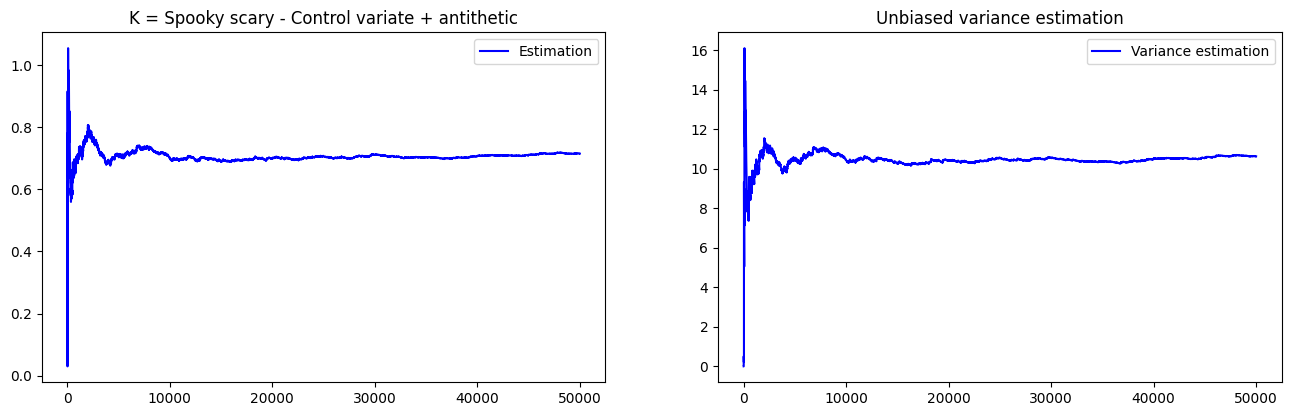

In [17]:
visualize_method_single_parameters(None, control_variate_antithetic_estimates, control_variate_antithetic_variances, "Spooky scary", "Control variate + antithetic")

# 3. porównanie

In [18]:
colors = [
    '#FF595E',
    '#FFCA3A'
]

Text(0.5, 1.0, 'Spooky scary option - method comparison')

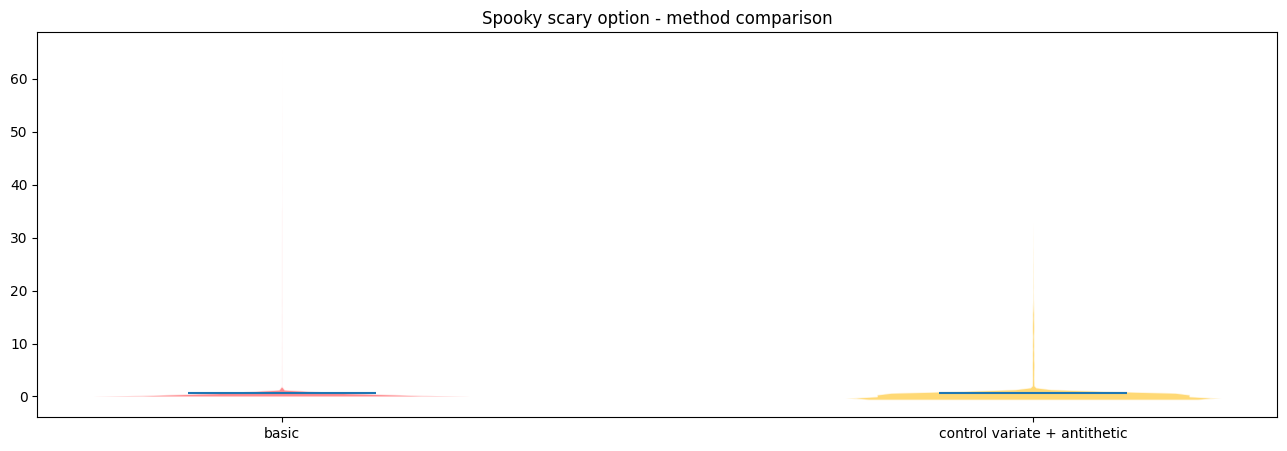

In [23]:
spooky_scary_data = [spooky_scary_payoffs, control_variate_values_merged]



ticks = ['basic', 'control variate + antithetic']
plt.figure(figsize=(16,5))
parts = plt.violinplot(spooky_scary_data, showmeans=True, showextrema=False)
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('white')
    body.set_alpha(0.7)
plt.xticks([1,2],ticks)
plt.title('Spooky scary option - method comparison')

Text(0.5, 1.0, 'Spooky scary option - method comparison')

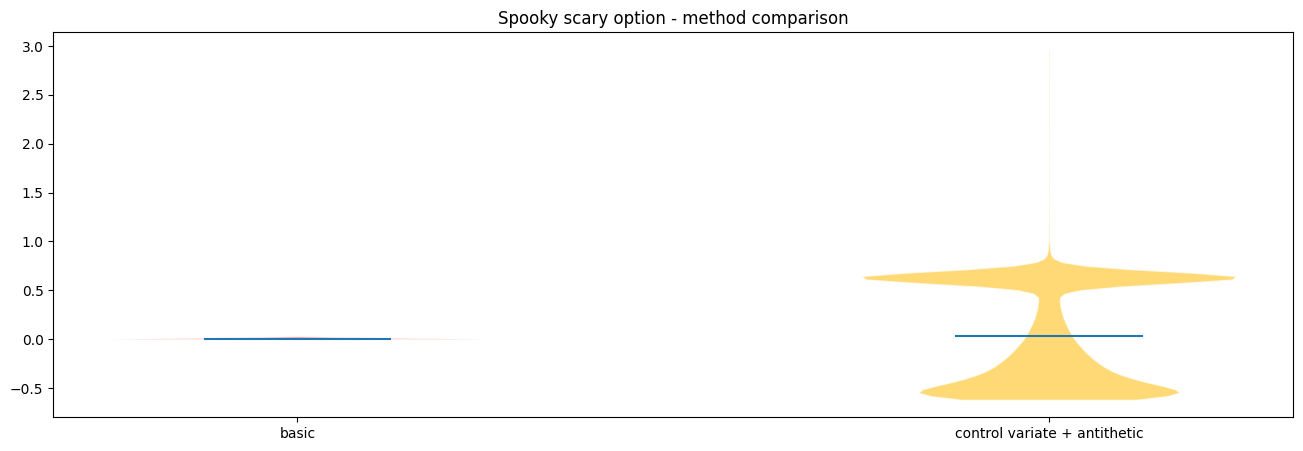

In [24]:
spooky_scary_data = [spooky_scary_payoffs, control_variate_values_merged]

#przy bazowej metodzie wariancję wyrabiają nieliczne ale naprawde OOUUUTTTTliery
for i in range(len(spooky_scary_data)):
    spooky_scary_data[i] = limit_array_to_range(spooky_scary_data[i], -1,3)


ticks = ['basic', 'control variate + antithetic']
plt.figure(figsize=(16,5))
parts = plt.violinplot(spooky_scary_data, showmeans=True, showextrema=False)
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('white')
    body.set_alpha(0.7)
plt.xticks([1,2],ticks)
plt.title('Spooky scary option - method comparison')

#### Nie wiem czy będzie to widac w full hd ale na monitorze 1440p widać pojedyncze czerwone piksele aż do samej góry wykresu